### Agente con consultas a una Base de Datos

Definimos el LLM

In [89]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()
openai_model = os.getenv("LLM_MODEL", "gpt-o4-mini")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(model= openai_model, temperature=0.5)

Definimos la herramienta que recuperará los productos de la base de datos

In [90]:
from langchain_community.utilities import SQLDatabase

username = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST", "localhost")  # Default to localhost
port = os.getenv("POSTGRES_PORT", "5432")  # Default PostgreSQL port
database = os.getenv("POSTGRES_DB", "mydatabase")  # Default database name

print(f"Connecting to database {database} at {host}:{port} as user {username}")

connection_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

dbEngine = SQLDatabase.from_uri(connection_uri)
print(dbEngine.dialect)
print(dbEngine.get_usable_table_names())

Connecting to database product_marketing at localhost:5432 as user user
postgresql
['products']


Usamos las herramientas proveidas por SQLDatabaseToolkit para listar las tablas

In [91]:
from langchain_core.tools import tool
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage

toolkit = SQLDatabaseToolkit(db=dbEngine, llm=llm)
tools = toolkit.get_tools()

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

def list_tables():
    """List all tables in the database."""
    return dbEngine.get_usable_table_names()

def get_schema():
    """Get the schema of the database."""
    
    return dbEngine.get_table_info()
    

list_tables_result = list_tables()
tables_schema = get_schema()

print(list_tables_result)
print(tables_schema)

['products']

CREATE TABLE products (
	id SERIAL NOT NULL, 
	name VARCHAR NOT NULL, 
	description VARCHAR, 
	CONSTRAINT products_pkey PRIMARY KEY (id)
)

/*
3 rows from products table:
id	name	description
1	Laptop	A high-performance laptop
2	Smartphone	A latest-gen smartphone
3	Laptop	A high-performance laptop for professionals.
*/


Definimos el estado el cual será mutado por los nodos

In [92]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """State of the agent."""
    question: str
    query: str 
    
    summary: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

Definimos los Nodos

In [93]:
from langchain_core.messages import  SystemMessage, AIMessage, FunctionMessage
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

default_number_rows = 5

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]
    
    
def generate_query(state: AgentState):
    
    
    generate_query_system_prompt = """
    Given an input question, create a syntactically correct {dialect} query to
    run to help find the answer. Unless the user specifies in his question a
    specific number of examples they wish to obtain, always limit your query to
    at most {top_k} results. You can order the results by a relevant column to
    return the most interesting examples in the database.

    Never query for all the columns from a specific table, only ask for a the
    few relevant columns given the question.

    Pay attention to use only the column names that you can see in the schema
    description. Be careful to not query for columns that do not exist. Also,
    pay attention to which column is in which table.

    Only use the following tables:
    {table_info}
    """.format(
        dialect=dbEngine.dialect,
        top_k=default_number_rows,
        table_info=tables_schema,
    )
    sys_message = SystemMessage(content=generate_query_system_prompt)
    structured_llm = llm.with_structured_output(QueryOutput)
    
    last_message = state["messages"][-1] if state["messages"] else None
    response = structured_llm.invoke([sys_message]+[last_message])
    query =response.get("query", "")
    
    response_message = AIMessage(
        content=f"Generated query: {query}"
    )

    return {"query": query, "messages": [response_message]}

def check_query(state: AgentState):
    
    check_query_system_prompt = """
    You are a SQL expert with a strong attention to detail.
    Double check the {dialect} query for common mistakes, including:
    - Using NOT IN with NULL values
    - Using UNION when UNION ALL should have been used
    - Using BETWEEN for exclusive ranges
    - Data type mismatch in predicates
    - Properly quoting identifiers
    - Using the correct number of arguments for functions
    - Casting to the correct data type
    - Using the proper columns for joins

    If there are any of the above mistakes, rewrite the query. If there are no mistakes,
    just reproduce the original query.

    You will call the appropriate tool to execute the query after running this check.
    """.format(dialect=dbEngine.dialect)
    
    sys_message = SystemMessage(content=check_query_system_prompt)
    query = state.get("query", "")
    
    query_message = AIMessage(content=query)
    
    response = llm.invoke([sys_message] + [query_message])

    return {"messages": [response]}

def run_query(state: AgentState):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=dbEngine)
    query = state.get("query", "")

    result = execute_query_tool.invoke(query)
    result_message = FunctionMessage(name="Sql_query", content=result)
    return {"messages": [result_message]}

Hacemos una arista condicional

In [94]:
# from typing import Literal

# def should_continue(state: AgentState) -> Literal["generate_query", "run_query"]:
#     messages = state["messages"]
#     last_message = messages[-1]
#     if not last_message.tool_calls:
#         return END
#     else:
#         return "check_query"

Construimos el grafo

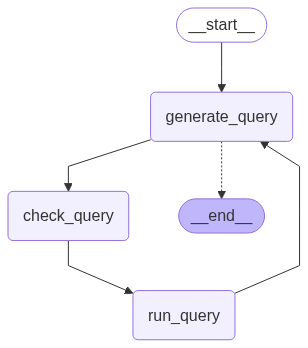

In [95]:
from langgraph.graph import START, StateGraph

builder = StateGraph(AgentState)
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query)

builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "check_query")
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

Pruebas

In [96]:
from langchain_core.messages import HumanMessage

pregunta = HumanMessage(content="¿What products are there?")

for step in agent.stream(
    {"messages": [pregunta]}, stream_mode="updates"
):
    if "messages" in step:
        step["messages"][-1].pretty_print()
    else:
        print(step)  # Or handle other keys like 'result'

{'generate_query': {'query': 'SELECT id, name, description FROM products LIMIT 5;', 'messages': [AIMessage(content='Generated query: SELECT id, name, description FROM products LIMIT 5;', additional_kwargs={}, response_metadata={}, id='80810d39-84ad-4bee-a275-7ef8a3a9111f')]}}
{'check_query': {'messages': [AIMessage(content='The query you provided is:\n\n```sql\nSELECT id, name, description FROM products LIMIT 5;\n```\n\nUpon reviewing the query for common mistakes, we note the following:\n\n1. **Using NOT IN with NULL values**: This query does not use `NOT IN`, so this point is not applicable.\n2. **Using UNION when UNION ALL should have been used**: There is no `UNION` or `UNION ALL` in this query, so this point is not applicable.\n3. **Using BETWEEN for exclusive ranges**: There is no `BETWEEN` clause in this query, so this point is not applicable.\n4. **Data type mismatch in predicates**: There are no predicates in this query, so this point is not applicable.\n5. **Properly quoting 

KeyboardInterrupt: 